In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import integrate, optimize
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc

In [3]:
rc('font',size=18)

In [69]:
s = 8
n = 1
Gamma = (n+1)/n
K = np.exp(s*(Gamma-1))
print(s,K,n,Gamma)
def get_rho_adm(P):
    return (P/K)**(1./Gamma)

8 2980.9579870417283 1 2.0


In [70]:
dr = 1e-1
PMIN = 1e-7
RMAX = 1e3

def rhs(r, u):
    m, p = u
    rho_adm = get_rho_adm(p)
    rhs = np.empty_like(u)
    if r == 0:
        rhs[0] = 0
        rhs[1] = 0
    else:
        rhs[0] = 4*np.pi*r*r*rho_adm
        dphidr = (m + 4*np.pi*(r**3)*p)/(r*(r-2*m))
        rhs[1] = -(rho_adm + p)*dphidr
    #print(r,u,r*(r-2*m),rhs)
    if p < PMIN:
        rhs[0] = 0
    return rhs

def get_mass_radius(rhoc):
    Pc = rhoc + (Gamma-1)*rhoc*eps
    integrator = integrate.ode(rhs)
    integrator.set_integrator('dopri5',atol=1e-12,rtol=1e-12)
    integrator.set_initial_value(np.array([0,Pc]))
    while integrator.successful() and integrator.y[1] > PMIN and integrator.t < RMAX:
        integrator.integrate(integrator.t + dr)
        #print(integrator.t,integrator.y)
    if integrator.t < RMAX:
        return integrator.y[0],integrator.t
    else:
        raise ValueError("Integration failed. State is:",integrator.t,integrator.y)

In [71]:
lrhocs = np.linspace(-7,-2,100)
rhocs = 10.**lrhocs
mvr = np.zeros((rhocs.shape[0],2))
for i,rhoc in enumerate(rhocs):
    try:
        mvr[i] = get_mass_radius(rhoc)
    except:
        continue

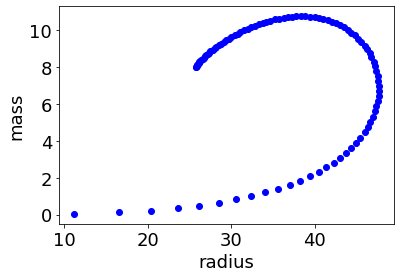

In [72]:
plt.plot(mvr[:,1],mvr[:,0],'bo')
plt.xlabel('radius')
plt.ylabel('mass')
plt.savefig('mass_radius_G1.png')

In [73]:
radii = np.linspace(0, 20, 10000)

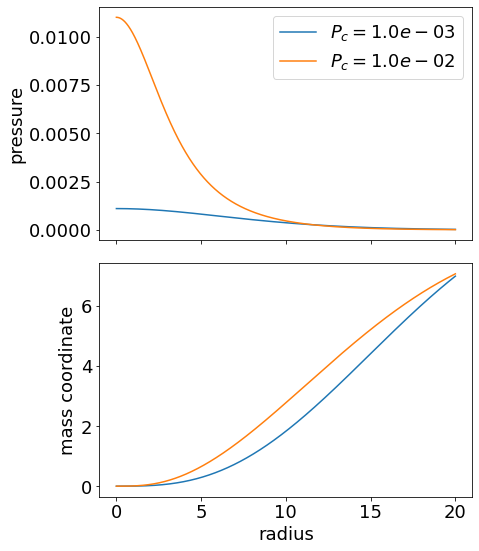

In [74]:
state = np.empty((radii.shape[0],2))

fig,axarr = plt.subplots(2,1,sharex=True,figsize=(7,8))

for rhoc in [1e-3,1e-2]:
    Pc = rhoc + (Gamma-1)*rhoc*eps
    state[0] = np.array([0,Pc])

    integrator = integrate.ode(rhs)
    integrator.set_integrator('dopri5')
    integrator.set_initial_value(np.array([0,Pc]))
    for i,r in enumerate(radii[1:]):
        integrator.integrate(r)
        state[i+1] = integrator.y
    axarr[0].plot(radii,state[:,1],label=(r'$P_c = %.1e$' % rhoc))
    axarr[1].plot(radii,state[:,0])

axarr[0].set_ylabel('pressure')
axarr[1].set_ylabel('mass coordinate')
axarr[1].set_xlabel('radius')
axarr[0].legend()
plt.tight_layout()

plt.savefig('gamma_law_tov_solutions.png',bbox_inches='tight')